# 4. Using the Iterative Targeted Fast Gradient Sign Attack to Generate Attack Samples

### About this notebook

This notebook was used in the 50.039 Deep Learning course at the Singapore University of Technology and Design.

**Author:** Matthieu DE MARI (matthieu_demari@sutd.edu.sg)

**Version:** 1.2 (06/07/2023)

**Requirements:**
- Python 3 (tested on v3.11.4)
- Matplotlib (tested on v3.7.1)
- Numpy (tested on v1.24.3)
- Pillow (tested on v9.3.0)
- Torch (tested on v2.0.1+cu118)
- Torchvision (tested on v0.15.2+cu118)

### Imports

In [1]:
# Future
from __future__ import print_function
# Matplotlib
import matplotlib.pyplot as plt
# Numpy
import numpy as np
# Pillow
from PIL import Image
# Torch
                  
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
# Torchvision
from torchvision import datasets, transforms

Total number of samples:  3180
Number of classes:  15
Number of samples per class:


<Figure size 1000x500 with 0 Axes>

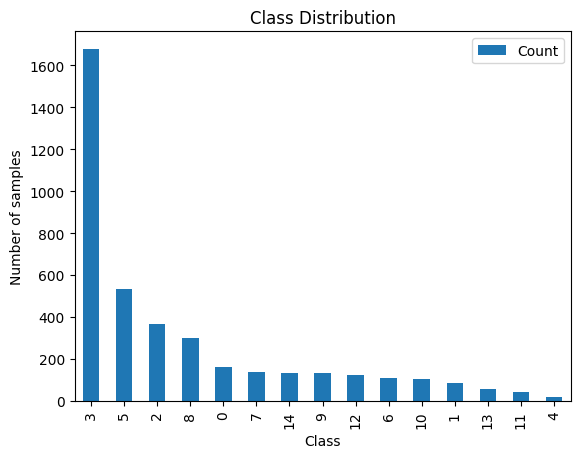

In [2]:
# # NOTE: This is a fix to work around the "User-agent" issue 
# # when downloading the MNIST dataset
# from six.moves import urllib
# opener_req = urllib.request.build_opener()
# opener_req.addheaders = [('User-agent', 'Mozilla/5.0')]
# urllib.request.install_opener(opener_req)

from dataset import ChestXrayDataset
import matplotlib.pyplot as plt

dataset = ChestXrayDataset()

# number of samples
print("Total number of samples: ", len(dataset))
# number of classes
print("Number of classes: ",len(dataset.get_labels()))
# number of samples per class
print("Number of samples per class:")
dataset.get_class_distribution()
plt.figure(figsize=(10, 5))
dataset.get_class_distribution().plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of samples')
plt.show()

### CUDA Setup

In [3]:
# Define device for torch
use_cuda = True
print("CUDA is available:", torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

CUDA is available: False


### Dataset and Dataloader

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=15):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2)
        # Assuming an input image size of 224x224, the feature map size is 56x56 after two pooling layers
        self.fc1 = nn.Linear(64 * 56 * 56, 1024)
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 56 * 56)  # Adjust the flattening to match the feature map size
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a common size
    transforms.Grayscale(num_output_channels=1),  # Convert images to grayscale
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),  # Adjust for grayscale images
])


train_dataset = ChestXrayDataset(transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)


In [ ]:
import copy

# Assuming train_dataset is your full dataset and you have not split it yet
# You would split your dataset here into train and validation sets
model = SimpleCNN(num_classes=15)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# Adjust num_epochs based on your dataset and training needs
num_epochs = 10
# Example: Splitting dataset (assuming you have a dataset object)
from torch.utils.data.dataset import random_split
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Then, create DataLoaders for your training and validation sets
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

best_val_loss = float('inf')
best_model_wts = copy.deepcopy(model.state_dict())

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}')

    # Save model if validation loss has decreased
    if avg_val_loss < best_val_loss:
        print(f'Validation loss decreased ({best_val_loss} --> {avg_val_loss}). Saving model ...')
        best_val_loss = avg_val_loss
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(model.state_dict(), 'best_model.pth')

# Load best model weights
model.load_state_dict(best_model_wts)


In [6]:

from attack import Attack

class Itfgsm(Attack):
    """
    ITFGSM: Iterative Targeted Fast Gradient Sign Method
    """
    def __init__(self, model):
        super(Itfgsm, self).__init__("ITFGSM", model)
        self.model.eval()

    def target_attack(self, image, target_label, epsilon=0.01, iters=10):
        # check if the image is batched
        if len(image.shape) == 3:
            image = image.unsqueeze(0)

        for i in range(iters):
            image = image.clone().detach().requires_grad_(True)
            output = self.model(image)[0]
            loss = nn.BCEWithLogitsLoss()(output, target_label)
            loss.backward()
            image_grad = image.grad.data
            image = image - epsilon * image_grad.sign()
            image = torch.clamp(image, 0, 1)
        return image

    def untargeted_attack(self, image, ori_label, epsilon=0.01, iters=10):
        # check if the image is batched
        if len(image.shape) == 3:
            image = image.unsqueeze(0)

        for i in range(iters):
            image = image.clone().detach().requires_grad_(True)
            output = self.model(image)[0]
            loss = nn.BCEWithLogitsLoss()(output, ori_label)
            loss.backward()
            image_grad = image.grad.data
            image = image + epsilon * image_grad.sign()
            image = torch.clamp(image, 0, 1)
        return image


In [ ]:
import torch

# Step 2. Prepare the model and optimizer
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = SimpleCNN(num_classes=15).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Step 3. Train the model
num_epochs = 10
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    total_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = nn.BCEWithLogitsLoss()(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    model.eval()

# Step 4. Save the model
model_path = "chest_xray_simpleCNN.pth"

torch.save(model.state_dict(), model_path)



Total number of samples:  3180
Number of classes:  15
Number of samples per class:


<Figure size 1000x500 with 0 Axes>

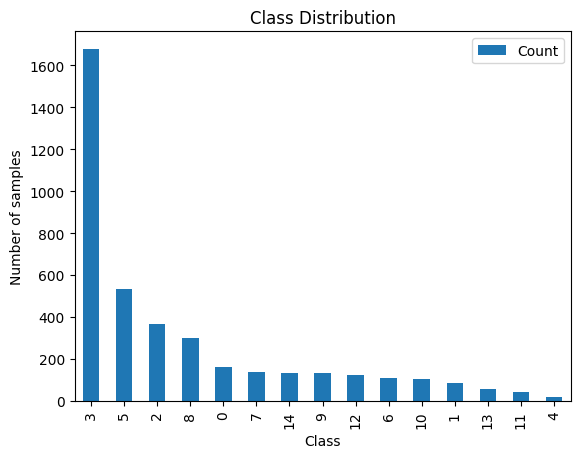

In [7]:
import os


from dataset import ChestXrayDataset
import matplotlib.pyplot as plt

testdata = ChestXrayDataset()

# number of samples
print("Total number of samples: ", len(testdata))
# number of classes
print("Number of classes: ",len(testdata.get_labels()))
# number of samples per class
print("Number of samples per class:")
testdata.get_class_distribution()
plt.figure(figsize=(10, 5))
testdata.get_class_distribution().plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of samples')
plt.show()

In [10]:
# Ensure the SimpleCNN class is defined in this scope
model = SimpleCNN(num_classes=15)


model_path = "chest_xray_simpleCNN.pth"
model.load_state_dict(torch.load(model_path, map_location=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')))
model.to(device)
model.eval()  # Set the model to evaluation mode


from torchvision import transforms


transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a common size
    transforms.Grayscale(num_output_channels=1),  # Convert images to grayscale
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),  # Adjust for grayscale images
])


test_dataset = ChestXrayDataset(transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)


from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader


model.eval()  # Set the model to evaluation mode
total = 0
correct = 0
with torch.no_grad():  # No gradients needed
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Convert one-hot encoded labels to class indices if necessary
        _, labels_indices = labels.max(dim=1)
        
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels_indices.size(0)
        correct += (predicted == labels_indices).sum().item()

print(f'Accuracy of the model on the test images: {100 * correct / total}%')


Accuracy of the model on the test images: 71.57232704402516%
